In [252]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
from joblib import Parallel, delayed
from pathlib import Path
from repeater import TakaAkiRepeaterCatalog
from earthquake import WaldhauserEarthquakeCatalog
from phase_util import phase_analysis, normalize_order_parameter
from figure_util import plot_phase_distribution
import copy

plt.rcParams.update({"font.size": 10})
plt.rcParams.update({"figure.dpi": 300})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Analysis of earthquake repeater synchronization
#### by Kelian Dascher-Cousineau & Roland Bürgmann

This notebook comprises the analysis of earthquake repeaters in the creeping section of the San Andreas Fault. The datasets include a reanalysis of reaters in northern California by Taka Aki Taira and the relocated (base) catalog for Northern California by Felix Waldhauser.

The overall approach is to use each repeater as a metronome and invesitage how synchronized nearby earthquakes and repeaters are to the beat set by the metronome.

### Data 

We consider the repeating earthquake catalog for Northern California assembled by Taira (in prep). Testing against previously identified repeater families, we found that a coherence threshold of 0.965 was best to identify charactersitic earthquake sequences. A higher threshold tends to break up repeating earthquake sequences into distinct families; a lower threshold tends to lead to pairs of nearby repeater families to be combined as one larger family with stuttered interevals. We consider families that have relatively regular occurrence, with a coefficient of variation less than 0.8 and at least 5 events. Conditioning on larger repeater families restricts the analysis almost entirely to the creeping section of the San Andreas Fault.

Table 1: Repeater families and their characteristics.


| Name | Values | Justification |
|------|--------|---------------|
| Coherence Threshold | 0.965 | Best to identify characteristic earthquake sequences. Higher threshold breaks up sequences; lower threshold combines nearby families. |
| Coefficient of Variation | 0.8 | Ensures relatively regular occurrence of events. |
| Minimum Number of Events | 5 | Focuses analysis on larger repeater families, mostly in the creeping section of the San Andreas Fault. |
| Minimum Average Magnitude | 2.0 | Focuses analysis on larger events, which are more likely to be characteristic of a repeating earthquake sequence. |

Table 2: Analysis parameters.

| Name | Values | Justification |
|------|--------|---------------|
| Search Radius | 0.05 - 2 km | Search radius on the order of repeater dimensions. |
| Number of Steps | 20 | NA |


In [253]:
data_config = {
    "directory": Path("data"),
    "repeaters": {
        "filename": "SJBPK.freq8-24Hz_maxdist3_coh9650_linkage_cluster.txt",
        "minimum_coefficient_of_variation": 0,
        "maximum_coefficient_of_variation": 0.8,
        "minimum_number_of_events": 5,
        "minimum_average_magnitude": 2,
    },
    "earthquakes": {
        "directory": Path("data/earthquake_catalogs/"),
        "filename": "NCEDC_DD.csv",
        "minimum_average_magnitude": 2.0,
    },
}

analysis_config = {
    "radius_range": [0.05, 2],  # km 
    "number_of_steps": 10,
}

In [254]:
print('Number of repeater families in original catalog: ', len(TakaAkiRepeaterCatalog(
        filename="SJBPK.freq8-24Hz_maxdist3_coh9650_linkage_cluster.txt"
).get_families()))

/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/repeater.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return bias_correction * np.std(dt) / np.mean(dt) if len(dt) > 2 else 0


Number of repeater families in original catalog:  4072


In [255]:
repeaters = (
    TakaAkiRepeaterCatalog(
        filename="SJBPK.freq8-24Hz_maxdist3_coh9650_linkage_cluster.txt"
    )
    .slice_by(
        "COV",
        data_config["repeaters"]["minimum_coefficient_of_variation"],
        data_config["repeaters"]["maximum_coefficient_of_variation"],
    )
    .slice_by("NEV", data_config["repeaters"]["minimum_number_of_events"])
)

minimum_avg_repeater_magnitude = data_config["repeaters"]["minimum_average_magnitude"]

for family in repeaters.catalog.family:

    if (
        repeaters.catalog.loc[repeaters.catalog.family == family].mag.mean()
        < minimum_avg_repeater_magnitude
    ):
        repeaters.catalog = repeaters.catalog.loc[repeaters.catalog.family != family]

minimum_avg_earthquake_magnitude = data_config["earthquakes"][
    "minimum_average_magnitude"
]

data_directory = data_config["earthquakes"]["directory"]

earthquakes = WaldhauserEarthquakeCatalog(
    data_directory / data_config["earthquakes"]["filename"]
)

# here we remove all the events in the Waldhauser earthquake catalog that are repeaters included in Taka's catalog to avoid double counting events.
new_df = earthquakes.catalog.merge(
    repeaters.catalog,
    how="left",
    left_on="EventID",
    right_on="EVID",
    indicator=True,
    suffixes=("", "_repeater"),
)

new_df_left_only = new_df.loc[new_df["_merge"] == "left_only"]
earthquakes.catalog = new_df_left_only

nearby_earthquakes = earthquakes.slice_by(
    "mag", minimum_avg_earthquake_magnitude
).intersection(repeaters)

print('Number of repeater families in new catalog: ', len(repeaters.get_families()))

/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/repeater.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return bias_correction * np.std(dt) / np.mean(dt) if len(dt) > 2 else 0


Number of repeater families in new catalog:  215


/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_47998/3243315842.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  family_catalog.catalog = family_catalog.catalog.groupby("family").mean()


491

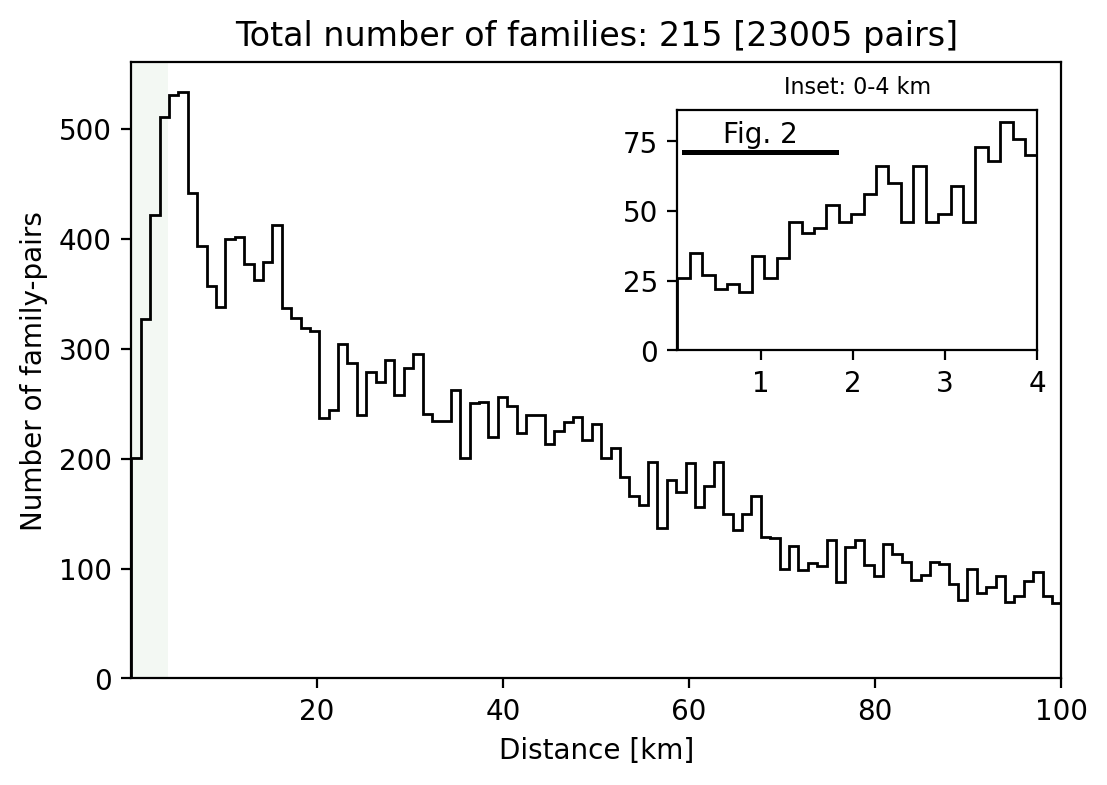

In [256]:
# aggregate repeater families to get average location and then calculate the distance to nearest family 
distance_range = [0, 100]
inset_range = [0, 4]
family_catalog = copy.deepcopy(repeaters)
family_catalog.catalog = family_catalog.catalog.groupby("family").mean()
_, D = family_catalog.get_neighboring_indices(family_catalog, buffer_radius_km=1000, return_distances=True)
D = np.concatenate(D)
D = np.unique(D)

# Main plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
ax.hist(D, bins=np.linspace(0.1, distance_range[1], 100), histtype="step", color='k')
ax.set_xlabel("Distance [km]")
ax.set_ylabel("Number of family-pairs")
ax.set_xlim([0.1, distance_range[1]])
ax.axvspan(0.1, 4, facecolor='darkseagreen', alpha=0.1)

# Inset plot
ax_inset = fig.add_axes([0.58, 0.52, 0.3, 0.3])  # Adjust the position and size of the inset as needed
ax_inset.hist(D, bins=np.linspace(0.1, inset_range[1], 30), histtype="step", color='k')
ax_inset.set_xlim([0.1, inset_range[1]])
ax_inset.set_title("Inset: 0-4 km", fontsize=8)

# add annotation over a bar from 0 to 2 km that say Fig. 2
ax_inset.text(1, 72.5, 'Fig. 2', fontsize=10, ha='center', va='bottom')
ax_inset.bar(1, 2, 2-0.3, 70, color='k')

ax.set_title('Total number of families: ' + str(len(family_catalog)) + ' [' + str(sum(D!=0)) + ' pairs]')
len(D)
sum(D<2)

## Establishing phase locking in a population, using repeaters as metronomes

For each repeater family we search for other families in the imediate neighborhood. The order parameter:

$$ R = \dfrac{1}{N}\left|\sum_{i=1}^N e^{i\phi_i}\right| $$

will approach 1 for a population that completely synchronize. Subtle effects related to higher order synchronization (e.g. period doubling) imply that R may not be a perfect measurmeent of synchronization. 

Since $\phi_i$ cannot be known in an absolute sense we make the following assuption that if the population synchronized, particularly regular repeater can serve a metronome. In this sense, for every repeater we measure:

$$ R \approx \dfrac{1}{N}\left|\sum_{i=1}^N e^{i 2\pi\dfrac{t_i - t_j}{t_{j+1}-t_j}}\right| $$  


In [257]:
method = "equal_spacing"
assert method in ["equal_volume", "equal_spacing"]

if method == "equal_volume":
    outer_radius = analysis_config["radius_range"][1]
    inner_radius = analysis_config["radius_range"][0]

    total_volume = 4 / 3 * np.pi * (outer_radius**3 - inner_radius**3)
    shell_volume = total_volume / analysis_config["number_of_steps"]

    search_radii = [analysis_config["radius_range"][0]]
    for i in range(analysis_config["number_of_steps"]):
        search_radii.append(
            (3 * shell_volume / (4 * np.pi) + search_radii[-1] ** 3) ** (1 / 3)
        )

elif method == "equal_spacing":
    search_radii = np.linspace(
        analysis_config["radius_range"][0],
        analysis_config["radius_range"][1],
        analysis_config["number_of_steps"],
    )

In [258]:
def analyze_phase(r1, r2):
    results = {}
    (
        order_parameter,
        earthquake_order_parameter,
        phases,
        raw_phases,
        raw_times,
        earthquake_phases,
        number_of_neighboring_repeaters,
        number_of_neighboring_earthquakes,
        delta_omega,
    ) = phase_analysis(repeaters, nearby_earthquakes, inner_radius=r1, outer_radius=r2)

    results["order_parameter"] = order_parameter
    results["earthquake_order_parameter"] = earthquake_order_parameter
    results["phases"] = phases
    results["number_of_neighboring_repeaters"] = number_of_neighboring_repeaters
    results["number_of_neighboring_earthquakes"] = number_of_neighboring_earthquakes
    results["raw_phases"] = raw_phases
    results["raw_times"] = raw_times
    results["earthquake_phases"] = earthquake_phases
    results["distance_range"] = [r1, r2]
    results["delta_omega"] = delta_omega
    return results


result_list = Parallel(n_jobs=-1)(
    delayed(analyze_phase)(r1, r2)
    for r1, r2 in zip(search_radii[:-1], search_radii[1:])
)

In [259]:
def normalize_results(results):
    
    phase_counts = [sum(~np.isnan(p)) for p in results["phases"]]
    results["normalized_order_parameter"] = normalize_order_parameter(
        results["order_parameter"], phase_counts
    )
    results["order_parameter_all_events"] = np.abs(
        np.nanmean(np.exp(1j * np.concatenate(results["phases"])))
    )
    
    total_phase_count = sum(phase_counts)
    results["normalized_order_parameter_all_events"] = normalize_order_parameter(
        [results["order_parameter_all_events"]],
        [total_phase_count],
    )
    results["total_phase_count"] = total_phase_count
    
    return results

result_list = Parallel(n_jobs=-1)(
    delayed(normalize_results)(results) for results in result_list
)

# measure the order parameter for all the events

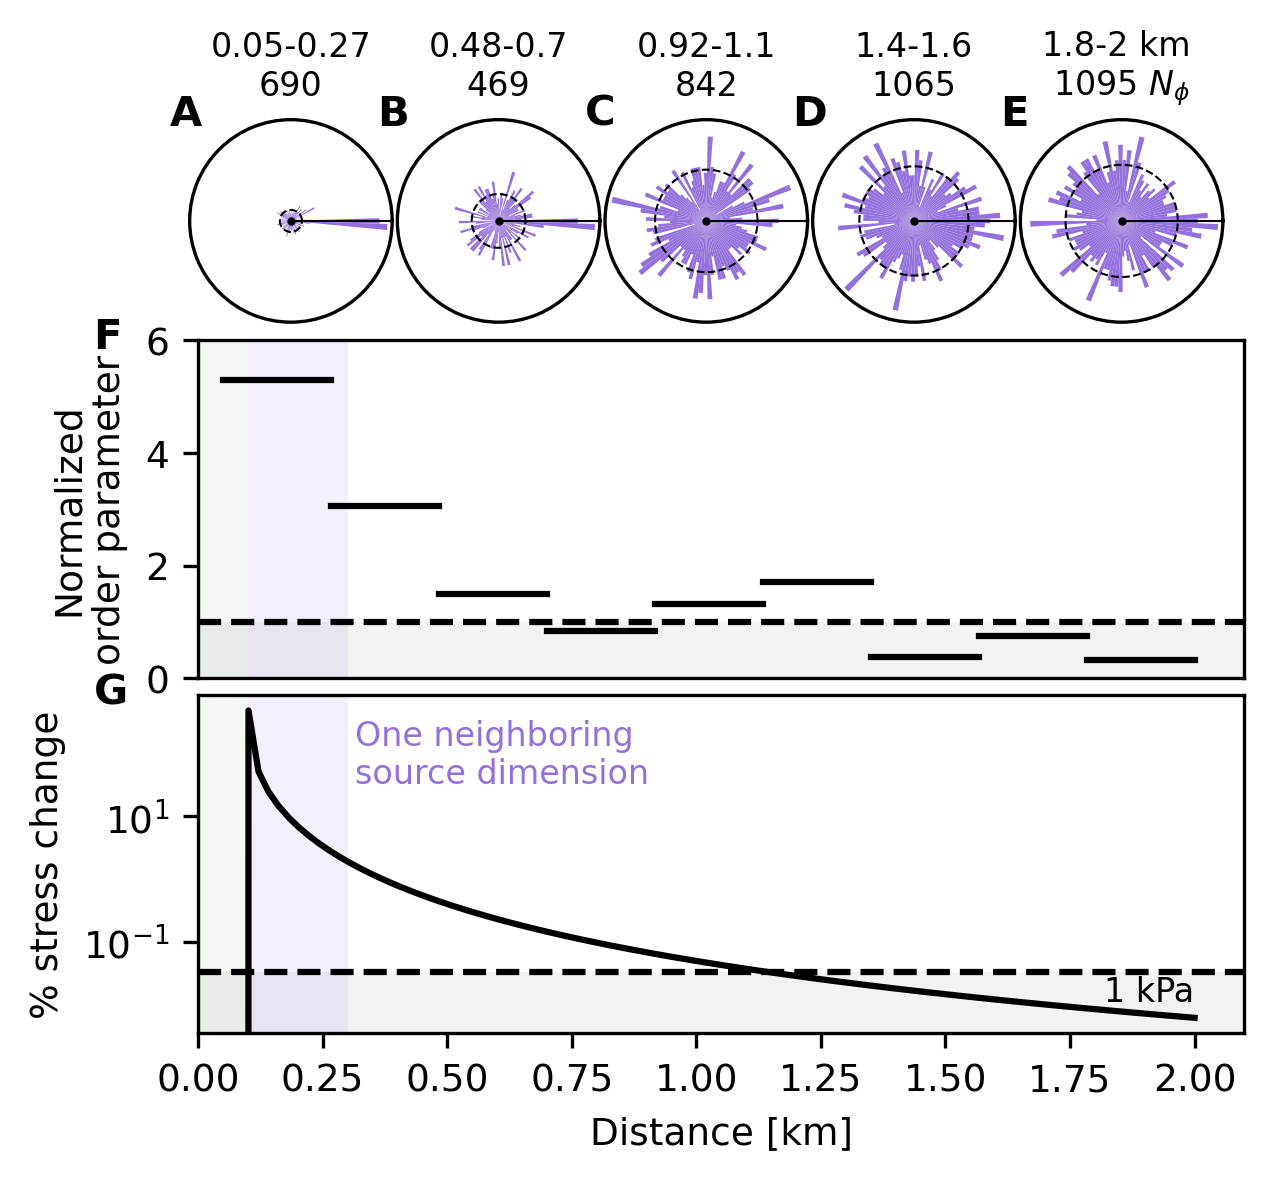

In [260]:
# set fontsize
plt.rcParams.update({"font.size": 9})

fig, AX = plt.subplots(2, 1, figsize=(4.5, 3), dpi=300, gridspec_kw={"hspace": 0.05})

letter_counter = 0
def add_letter(letter_counter, ax):
    ax.text(-0.1, 0.975, f"{chr(65+letter_counter)}", transform=ax.transAxes, fontsize=10, fontweight="bold")

ax = AX[0]

order_parameter = [
    results["normalized_order_parameter_all_events"]
    for results in result_list
]

ax.axhline(1, c="k", ls="--")
for i in range(len(search_radii) - 1):
    ax.plot(
        [search_radii[i], search_radii[i + 1]],
        [order_parameter[i], order_parameter[i]],
        c="k",
    )

ax.set(ylabel="Normalized\norder parameter")

# green to purple
ax.axvspan(0.0, 0.1, facecolor="darkseagreen", alpha=0.1)
ax.axvspan(0.1, 0.3, facecolor="mediumpurple", alpha=0.1)
ax.axhspan(0.0, 1, facecolor="grey", alpha=0.1)

# make x axis tight:
ax.set_xlim([0, 2.1])
ax.set_ylim([0, 6])

ax.set_xticks([])


# Add phase diagrams as insets
for i, results in enumerate(result_list):
    if i % 2 == 0:
        inset_ax = fig.add_axes(
            [
                # Calculate the x position of the inset axes
                0.025
                + (results["distance_range"][0] + results["distance_range"][1])
                / 2
                / search_radii[-1]
                * 0.71,
                # Set the y position of the inset axes
                0.9,
                # Set the width of the inset axes
                0.225,
                # Set the height of the inset axes
                0.225,
            ],
            projection="polar",
        )
        ax = plot_phase_distribution(results["phases"], stacked=False, ax=inset_ax)
        ax.set_title(
            f'{results["distance_range"][0]:0.2g}-{results["distance_range"][1]:0.2g}\n{len(np.concatenate(results["phases"]))}',
            fontsize=8,
        )
        
        add_letter(letter_counter, ax)
        letter_counter += 1

ax.set_title(
            f'{results["distance_range"][0]:0.2g}-{results["distance_range"][1]:0.2g} km \n{len(np.concatenate(results["phases"]))}' + r' $N_{\phi}$',
            fontsize=8,
)

ax = AX[1]

# plot stress decay away from the repeater source following dieterich 1994
xs = np.linspace(0, search_radii[-1], 100)
delta_tau_E = -3e6


def dieterich94_sptial_kernel(x, delta_tau_E=-3e6, c=20e3) -> np.ndarray:
    shear_stress_change = np.zeros_like(x)
    shear_stress_change[x > c] = -delta_tau_E * ((1 - c**3 / x[x > c] ** 3) ** -0.5 - 1)
    shear_stress_change[x <= c] = delta_tau_E
    return shear_stress_change


ax.plot(
    xs,
    -dieterich94_sptial_kernel(xs, delta_tau_E=delta_tau_E, c=0.1) / delta_tau_E * 100,
    c="k",
)
ax.set_yscale("log")
ax.set(xlabel="Distance [km]", ylabel="% stress change")
ax.axhline(1e3 / -delta_tau_E * 100, c="k", ls="--")
ax.axhspan(0.0, 1e3 / -delta_tau_E * 100, facecolor="grey", alpha=0.1)

ax.axvspan(0.0, 0.1, facecolor="darkseagreen", alpha=0.1)
ax.axvspan(0.1, 0.3, facecolor="mediumpurple", alpha=0.1)

ax.text(
    xs[-1],
    1e3 / -delta_tau_E * 0.9 * 100,
    "1 kPa",
    ha="right",
    va="top",
    fontsize=8,
    color="k",
)

ax.text(
    (0.1+0.2)*1.05,  # x-coordinate
    0.95 * 100,  # y-coordinate
    "One neighboring\nsource dimension",
    ha="left",
    va="center",
    fontsize=8,
    color="mediumpurple",
)
ax.set_xlim([0, 2.1])

for ax in AX:
    add_letter(letter_counter, ax)
    letter_counter += 1

# save figure
fig.savefig("figures/order_parameter.pdf", bbox_inches="tight")


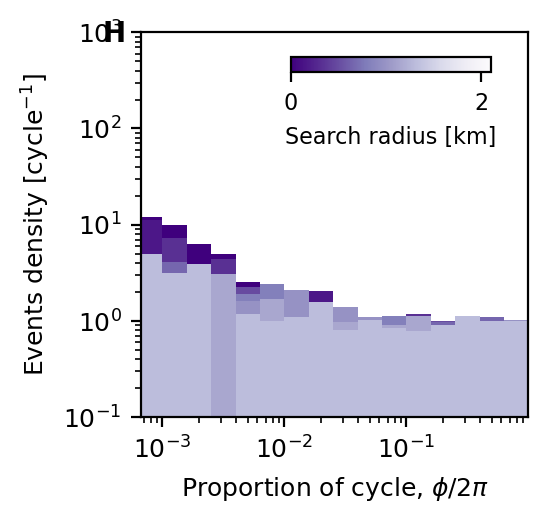

In [261]:
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=200)

# Create a normalization for the colormap
norm = plt.Normalize(
    analysis_config["radius_range"][0], 
    analysis_config["radius_range"][1],
)
sm = plt.cm.ScalarMappable(cmap=plt.cm.Purples_r, norm=norm)

colors = plt.cm.Purples_r(np.linspace(0,0.7, analysis_config["number_of_steps"]))

for i, results in enumerate(result_list):
    cycle = np.concatenate(results["phases"]) / (np.pi * 2)
    bins = np.logspace(
        -5,
        np.log10(np.pi * 2),
        30,
    )
    ax.hist(
        cycle,
        bins=bins,
        log=True,
        color=colors[i],
        linewidth=0.5,
        density=True,
        label=f'{results["distance_range"][0]:0.2g} - {results["distance_range"][1]:0.2g} km',
    )

ax.set(
    xscale="log",
    xlabel=r"Proportion of cycle, $\phi/2\pi$",
    ylabel=r"Events density [cycle$^{-1}$]",
    xlim=[np.min(cycle), np.max(cycle)],
    ylim=[10**-1, 10**3],
)

# Add colorbar in top right corner
cax = fig.add_axes([0.425, 0.8, 0.4, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_label("Search radius [km]", fontsize=8)
cbar.mappable.set_clim(0, 2.1)
cbar.ax.tick_params(labelsize=8)

add_letter(letter_counter, ax)

# save figure
fig.savefig("figures/scale_break.pdf", bbox_inches="tight")


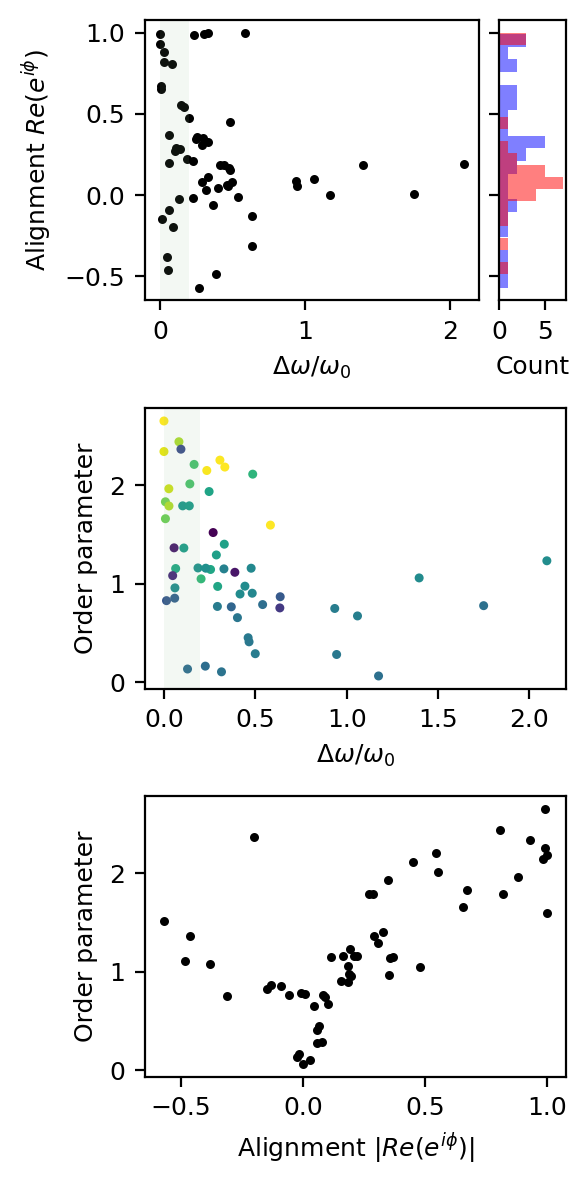

In [262]:
# id like to test the extent to which a small difference in the avergate
# period compared to the metronome corresponds to a small phase difference:

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, AX = plt.subplots(3,1, figsize=(3, 6), dpi=200)
N = 1
for results in result_list[:N]:

    phases = results["phases"]
    delta_omega = results["delta_omega"]
    order_parameter = results["normalized_order_parameter"]

    ax = AX[0]
    alignment_less_than_0_2 = []
    alignment_greater_than_0_2 = []

    for i_delta_omega, i_phases in zip(delta_omega, phases):
        if i_phases.size > 0 and i_delta_omega.size > 0:
            alignment = np.real(np.mean(np.exp(1j * i_phases)))
            ax.scatter(
                np.abs(i_delta_omega[0]), 
                alignment,
                c="k",
                s=5,
            )
            if np.abs(i_delta_omega[0]) < 0.3:
                alignment_less_than_0_2.append(alignment)
            else:
                alignment_greater_than_0_2.append(alignment)

    divider = make_axes_locatable(ax)
    ax_hist = divider.append_axes("right", size="20%", pad=0.1, sharey=ax)
    ax_hist.hist(alignment_less_than_0_2, bins=20, orientation='horizontal', color='blue', alpha=0.5, label=r"$\Delta\omega / \omega_0 < 0.2$")
    ax_hist.hist(alignment_greater_than_0_2, bins=20, orientation='horizontal', color='red', alpha=0.5, label=r"$\Delta\omega / \omega_0 \geq 0.2$")
    ax_hist.set_xlabel('Count')
    plt.setp(ax_hist.get_yticklabels(), visible=False)

    ax.set(
        xlabel=r"$\Delta\omega / \omega_0$",
        ylabel=r"Alignment $Re(e^{i\phi})$",
    )

    ax.axvspan(0.0, 0.2, facecolor="darkseagreen", alpha=0.1)

    ax = AX[1]
    ax.scatter(
        [np.abs(i_delta_omega[0]) for i_delta_omega in delta_omega if i_delta_omega.size > 0], 
        [order_parameter[i] for i in range(len(order_parameter)) if delta_omega[i].size > 0], 
        c=[np.real(np.mean(np.exp(1j * i_phases))) for i_phases in phases if i_phases.size > 0],
        s=5,
    )
    ax.set(
        xlabel=r"$\Delta\omega / \omega_0$",
        ylabel="Order parameter",
    )

    ax.axvspan(0.0, 0.2, facecolor="darkseagreen", alpha=0.1)

    ax = AX[2]
    ax.scatter(
        [np.real(np.mean(np.exp(1j * i_phases))) for i_phases in phases if i_phases.size > 0], 
        [order_parameter[i] for i in range(len(order_parameter)) if phases[i].size > 0], 
        c="k",
        s=5,
    )

    ax.set(
        xlabel=r"Alignment $|Re(e^{i\phi})|$",
        ylabel="Order parameter",
    )

plt.tight_layout()


[]

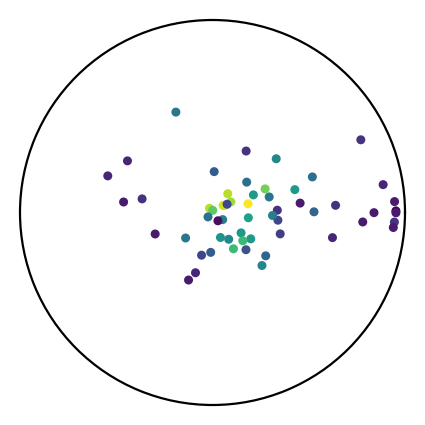

In [263]:
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=200, subplot_kw={"projection": "polar"})
ax.scatter(
    [np.angle(np.mean(np.exp(1j * i_phases))) for i_phases in phases if i_phases.size > 0],
    [np.abs(np.mean(np.exp(1j * i_phases))) for i_phases in phases if i_phases.size > 0],
    c=[len(i_phases) for i_phases in phases if i_phases.size > 0],
    s=5,
)
# remover all the ticks and labels
ax.set_xticks([])
ax.set_yticks([])

